In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
import itertools
from keras.layers.core import Lambda
from keras.preprocessing import image
from keras.layers.core import Dropout, Lambda
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam, Adadelta
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [0]:


import scipy.io as sio
My_data = sio.loadmat('drive/Plant Classification Using C-CNN/train/Image_Processed_1data.mat')
x_train = My_data['train']
labels = My_data["train_labels"]

CPU times: user 445 ms, sys: 1.37 s, total: 1.82 s
Wall time: 16.3 s


In [0]:
x_train, x_val, y_train, y_val = train_test_split(x_train, labels, test_size = 0.1, random_state=10, stratify=labels)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.1, random_state=10, stratify =y_train)



CPU times: user 47.4 s, sys: 1.63 s, total: 49.1 s
Wall time: 49.1 s


In [0]:
print('Train data:', len(x_train), ', Test data:', len(x_test), ', Train labels:', len(y_train), ', Test labels:', len(y_test))

Train data: 4498 , Test data: 500 , Train labels: 4498 , Test labels: 500


In [0]:
input_shape = x_train[1].shape
print('Input Shape is :', input_shape)

Input Shape is : (256, 256, 4)


In [0]:
#Model

def Conv_layer(filter_size, inp):
  cv1 = Conv2D(filter_size, (3,3), padding='same')(inp)
  cv1 = LeakyReLU(alpha=0.15)(cv1)
  cv1 = Dropout(0.1)(cv1)
  cv1 = Conv2D(filter_size, (3,3), padding='same')(cv1)
  out = LeakyReLU(alpha=0.15)(cv1)
  return out
  
def Pooling(inp):
  mp1 = MaxPooling2D((2, 2))(inp)
  return mp1


#cv2 = Conv2D(16, (3,3), padding='same')(mp1)
#cv2 = LeakyReLU(alpha=0.15)(cv2)
#cv2 = Dropout(0.1)(cv2)
#cv2 = Conv2D(16, (3,3), padding='same')(cv2)
#cv2 = LeakyReLU(alpha=0.15)(cv2)
#mp2 = MaxPooling2D((2, 2))(cv2)

def Upsampling(filter_size, inp, feedforward):
  up1 = Conv2DTranspose(filter_size, (2, 2), strides=(2, 2), padding='same') (inp)
  up1 = concatenate([up1, feedforward])
  up1 = Conv2D(filter_size, (3,3), padding='same')(up1)
  up1 = LeakyReLU(alpha=0.15)(up1)
  up1 = Dropout(0.1)(up1)
  up1 = Conv2D(filter_size, (3,3), padding='same')(up1)
  out = LeakyReLU(alpha=0.15)(up1)
  return out

image_input=Input(shape=input_shape)
ip = Lambda(lambda x: x / 255) (image_input)

l1 = Conv_layer(8, ip)
p1 = Pooling(l1)

l2 = Conv_layer(16, p1)
p2 = Pooling(l2)

l3 = Conv_layer(32, p2)
p3 = Pooling(l3)

l4 = Conv_layer(64, p3)

u1 = Upsampling(32, l4, l3)
u2 = Upsampling(16, u1, l2)
u3 = Upsampling(8, u2, l1)

d1 = Flatten()(u3)
d1 = Dense(512)(d1)
d1 = Dropout(0.5)(d1)
d1 = LeakyReLU(alpha=0.1)(d1)

d2 = Dense(256)(d1)
d2 = Dropout(0.2)(d2)
d2 = LeakyReLU(alpha=0.1)(d2)

out = Dense(12, activation='softmax')(d2)

model_new = Model(image_input, out)
model_new.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_new.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 4)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 4)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  296         lambda_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 256, 256, 8)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 

In [0]:
#earlystopper = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
#checkpointer = ModelCheckpoint('drive/Plant Classification Using C-CNN/Models/FPN/FPN1.h5.h5', monitor='val_acc', verbose=1, save_best_only=True)
history = model_new.fit(x_train, y_train,validation_split=0.1, epochs=7, batch_size=50)
                    

Train on 4048 samples, validate on 450 samples
Epoch 1/7
4048/4048 [==============================] - 101s 25ms/step - loss: 2.5398 - acc: 0.3078 - val_loss: 1.6944 - val_acc: 0.4733
Epoch 2/7
4048/4048 [==============================] - 92s 23ms/step - loss: 1.2802 - acc: 0.5704 - val_loss: 1.5586 - val_acc: 0.4844
Epoch 3/7
4048/4048 [==============================] - 92s 23ms/step - loss: 0.9934 - acc: 0.6648 - val_loss: 1.6314 - val_acc: 0.5022
Epoch 4/7
2900/4048 [====================>.........] - ETA: 25s - loss: 0.7925 - acc: 0.7310

4048/4048 [==============================] - 92s 23ms/step - loss: 0.7709 - acc: 0.7374 - val_loss: 1.0429 - val_acc: 0.6889
Epoch 5/7
4048/4048 [==============================] - 92s 23ms/step - loss: 0.5661 - acc: 0.8110 - val_loss: 1.1913 - val_acc: 0.6822
Epoch 6/7
4048/4048 [==============================] - 92s 23ms/step - loss: 0.4417 - acc: 0.8577 - val_loss: 1.1009 - val_acc: 0.7156
Epoch 7/7
4048/4048 [==============================] - 92s 23ms/step - loss: 0.2954 - acc: 0.9103 - val_loss: 1.4070 - val_acc: 0.6600


In [0]:

y_val_pred = model_new.evaluate(x_val, y_val, batch_size=32, verbose=1, sample_weight=None)

print()
print ("Validation Loss = " + str(y_val_pred[0]))
print ("Validation Accuracy = " + str(y_val_pred[1]))

556/556 [==============================] - 4s 7ms/step

Validation Loss = 1.5783734047155586
Validation Accuracy = 0.6258992805755396


In [0]:

y_test_pred = model_new.evaluate(x_test, y_test, batch_size=32, verbose=1, sample_weight=None)

print()
print ("Test Loss = " + str(y_test_pred[0]))
print ("Test Accuracy = " + str(y_test_pred[1]))

500/500 [==============================] - 3s 7ms/step

Test Loss = 1.428854314804077
Test Accuracy = 0.6659999990463257


In [0]:

y_train_pred = model_new.evaluate(x_train, y_train, batch_size=32, verbose=1, sample_weight=None)

print()

4498/4498 [==============================] - 26s 6ms/step



In [0]:
print ("Train Loss = " + str(y_train_pred[0]))
print ("Train Accuracy = " + str(y_train_pred[1]))

Train Loss = 0.342158630324661
Train Accuracy = 0.9068474878253487


In [0]:
y_train_pred =model_new.predict(x_train, batch_size=64, verbose=1, steps=None)
y_test_pred =model_new.predict(x_test, batch_size=64, verbose=1, steps=None)
y_val_pred =model_new.predict(x_val, batch_size=64, verbose=1, steps=None)

556/556 [==============================] - 3s 6ms/step


In [0]:
y_train_pred = np.argmax(y_train_pred, axis=1)
y_test_pred = np.argmax(y_test_pred, axis=1)
y_val_pred = np.argmax(y_val_pred, axis=1)

In [0]:
y_train_x = np.argmax(y_train, axis=1)
y_test_x = np.argmax(y_test, axis=1)
y_val_x = np.argmax(y_val, axis=1)

Classification Matrix
[[216   0   0   1   9   2  23   0   0   0   0   0]
 [  0 344  15   0   3   0   0   0   3   0   0   1]
 [  0   0 252   0  13   0   0   0   0   0   1   5]
 [  0   0   1 545   7  19   1   1   1   0   1   2]
 [  2   0   0   0 195   0   8   0   0   0   0   0]
 [  1   1   3   0  58 356  12   0   0   1   0   4]
 [  6   0   0   0  12   2 600   0   0   0   0   0]
 [  0   0   0   1   9   5   0 191   1   0   0   1]
 [  1   1  10   1  79   5   2   1 381   2   0   9]
 [  0   0   5   4   6   5   0   3   1 195   1   2]
 [  0   3  10   1   2   6   3   0   0   1 448   0]
 [  1   2   4   1   3   4   1   1   0   0   2 356]]
Confusion matrix
[[0.86 0.   0.   0.   0.04 0.01 0.09 0.   0.   0.   0.   0.  ]
 [0.   0.94 0.04 0.   0.01 0.   0.   0.   0.01 0.   0.   0.  ]
 [0.   0.   0.93 0.   0.05 0.   0.   0.   0.   0.   0.   0.02]
 [0.   0.   0.   0.94 0.01 0.03 0.   0.   0.   0.   0.   0.  ]
 [0.01 0.   0.   0.   0.95 0.   0.04 0.   0.   0.   0.   0.  ]
 [0.   0.   0.01 0.   0.13 0.82 0

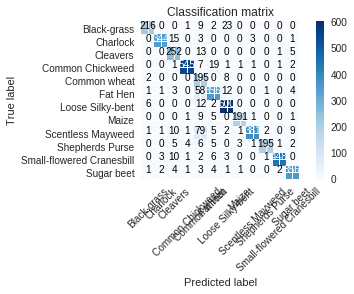

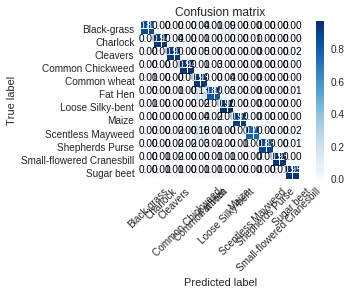

In [0]:
from sklearn.metrics import confusion_matrix
SPECIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen',
              'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse',
              'Small-flowered Cranesbill', 'Sugar beet']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion matrix")
    else:
        print('Classification Matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix for Train
cnf_matrix = confusion_matrix(y_train_x, y_train_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=SPECIES,
                      title='Classification matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=SPECIES, normalize=True,
                      title='Confusion matrix')



plt.show()



Classification Matrix
[[ 6  0  0  0  2  0 20  0  0  0  0  0]
 [ 1 31  4  0  0  1  0  1  1  0  1  1]
 [ 0  1 28  0  1  0  0  0  0  0  0  0]
 [ 1  0  0 52  1  6  0  1  0  0  1  2]
 [ 5  0  0  0 10  0  8  0  0  0  0  0]
 [ 0  2  2  2 10 20  8  0  2  0  0  2]
 [ 5  0  0  1  4  1 56  0  0  0  2  0]
 [ 0  1  0  1  2  2  1 14  2  0  0  0]
 [ 0  0  0  0 16  0  3  0 31  0  0  4]
 [ 0  0  0  2  0  4  0  1  1 15  1  1]
 [ 0  3  2  2  0  4  1  1  0  0 38  2]
 [ 0  0  1  1  4  3  0  0  0  0  1 32]]
Confusion matrix
[[0.21 0.   0.   0.   0.07 0.   0.71 0.   0.   0.   0.   0.  ]
 [0.02 0.76 0.1  0.   0.   0.02 0.   0.02 0.02 0.   0.02 0.02]
 [0.   0.03 0.93 0.   0.03 0.   0.   0.   0.   0.   0.   0.  ]
 [0.02 0.   0.   0.81 0.02 0.09 0.   0.02 0.   0.   0.02 0.03]
 [0.22 0.   0.   0.   0.43 0.   0.35 0.   0.   0.   0.   0.  ]
 [0.   0.04 0.04 0.04 0.21 0.42 0.17 0.   0.04 0.   0.   0.04]
 [0.07 0.   0.   0.01 0.06 0.01 0.81 0.   0.   0.   0.03 0.  ]
 [0.   0.04 0.   0.04 0.09 0.09 0.04 0.61 0.09 0.  

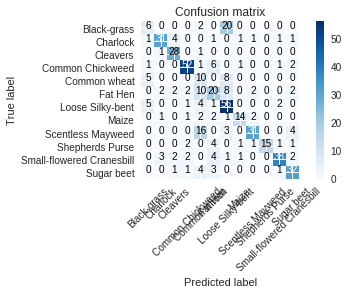

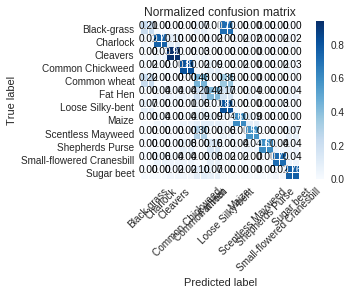

In [0]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_x, y_test_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=SPECIES,
                      title='Confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=SPECIES, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Classification Matrix
[[ 3  0  0  0  3  1 24  0  0  0  0  0]
 [ 0 35  8  0  0  0  0  1  0  0  0  1]
 [ 0  0 19  1  8  1  0  0  1  0  0  4]
 [ 0  0  0 53  2  8  2  1  2  0  1  2]
 [ 2  0  0  0 11  0 12  0  0  0  0  0]
 [ 0  2  2  1 22 24  2  0  0  0  0  1]
 [ 3  0  0  1 11  3 58  0  0  0  1  0]
 [ 0  0  1  1  0  0  0 23  0  0  0  1]
 [ 0  2  4  0 11  3  2  0 32  1  0  6]
 [ 0  0  3  2  2  5  0  2  1 10  0  2]
 [ 2  1  3  2  0  1  0  2  0  0 48  0]
 [ 3  0  1  1  6  2  1  0  0  0  0 32]]
Confusion matrix
[[0.1  0.   0.   0.   0.1  0.03 0.77 0.   0.   0.   0.   0.  ]
 [0.   0.78 0.18 0.   0.   0.   0.   0.02 0.   0.   0.   0.02]
 [0.   0.   0.56 0.03 0.24 0.03 0.   0.   0.03 0.   0.   0.12]
 [0.   0.   0.   0.75 0.03 0.11 0.03 0.01 0.03 0.   0.01 0.03]
 [0.08 0.   0.   0.   0.44 0.   0.48 0.   0.   0.   0.   0.  ]
 [0.   0.04 0.04 0.02 0.41 0.44 0.04 0.   0.   0.   0.   0.02]
 [0.04 0.   0.   0.01 0.14 0.04 0.75 0.   0.   0.   0.01 0.  ]
 [0.   0.   0.04 0.04 0.   0.   0.   0.88 0.   0.  

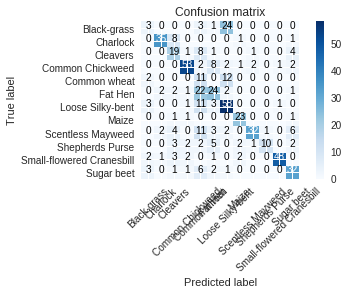

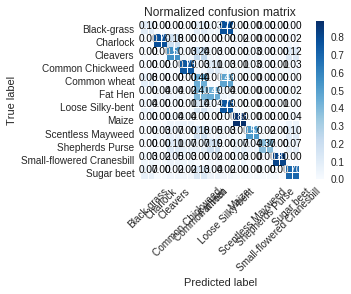

In [0]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val_x, y_val_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=SPECIES,
                      title='Confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=SPECIES, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:638: UserWarning: Unrecognized location "upper centre". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


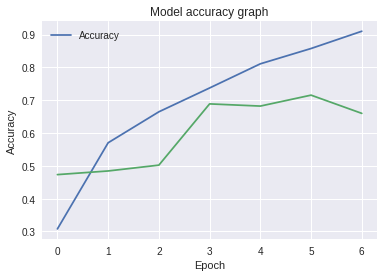

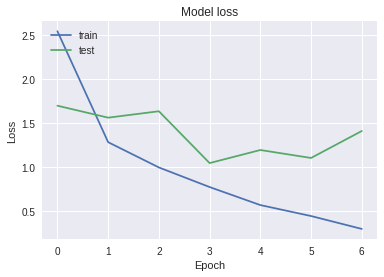

In [0]:
from matplotlib import axes as plt2
from matplotlib import pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
#plt.plot(history.history['loss'])
plt.title('Model accuracy graph')
plt.ylabel('Accuracy')

plt.xlabel('Epoch')
plt.legend(['Accuracy'], loc='upper centre')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()